# ngmix validation

Test measured sizes and different SNR estimates for ngmix/metacal runs on galaxy profiles.

Run `fitting_sp_v3.py` first.

The `sp_validation` kernel works.

In [1]:
import os
import numpy as np
from astropy.io import ascii
import matplotlib.pylab as plt
from adjustText import adjust_text
from lmfit import minimize, Parameters

from cs_util import plots as csp
from cs_util import calc

In [2]:
# ShapePipe and ngmix interfaces
keys = ["sp", "ng"]
#keys = ["sp"]

markers = {"sp": "o", "ng": "s"}
colors = {"sp": "b", "ng": "orange"}
colors2 = {"sp": "g", "ng": "red"}

color_arr = ["b", "orange"]

In [3]:
profile = os.path.split(os.path.dirname(f"{os.getcwd()}/."))[1]
print(profile)

Gaussian


In [4]:
# List of input galaxy half-light radii in arcsec
gal_hlr_arr = [0.5, 1.0]

# List of PSF sizes (FWHM), in arcsec
psf_arr = [0.68, 0.93]

# Read data and create data dictionary
dat = {}
dirs = []

for gal_hlr in gal_hlr_arr:
    for psf in psf_arr:
        direc = f"gal_hlr_{gal_hlr}_psf_{psf}"
        dirs.append(direc)
        print(direc)
        dat[direc] = ascii.read(f"{direc}/T.txt", format="commented_header")

gal_hlr_0.5_psf_0.68
gal_hlr_0.5_psf_0.93
gal_hlr_1.0_psf_0.68
gal_hlr_1.0_psf_0.93


In [5]:
# Compute mean and standard deviation of object size for each flux

# Size and standard deviation averaged over realisations
T_mean = {}
T_std = {}
flux_mean = {}
flux_std = {}
SNR_mean = {}

# Measured size error averaged over realisations
T_err = {}
flux_err = {}

for key in keys:
    T_mean[key] = {}
    T_std[key] = {}
    T_err[key] = {}
    flux_mean[key] = {}
    flux_std[key] = {}
    flux_err[key] = {}
    SNR_mean[key] = {}
    for direc in dirs:
        T_mean[key][direc] = []
        T_std[key][direc] = []
        T_err[key][direc] = []
        flux_mean[key][direc] = []
        flux_std[key][direc] = []
        flux_err[key][direc] = []
        SNR_mean[key][direc] = []

n_per_flux = -1
dat0 = dat[dirs[0]]
fluxes = list(set(dat0["Flux"]))
for flux in fluxes:
    idx = np.where(dat0["Flux"] == flux)[0]
    if n_per_flux == -1:
        n_per_flux = len(idx)

    for key in keys:
        for direc in dirs:
            mydat = dat[direc]

            # Compute weighted means and standard deviations
            mean, std = calc.weighted_avg_and_std(mydat[f"T_{key}"][idx], 1 / mydat[f"T_err_{key}"][idx] ** 2)
            T_mean[key][direc].append(mean)
            T_std[key][direc].append(std)
            T_err[key][direc].append(np.mean(mydat[f"T_err_{key}"]))

            mean, std = calc.weighted_avg_and_std(mydat[f"flux_{key}"][idx], 1 / mydat[f"flux_err_{key}"][idx] ** 2)
            flux_mean[key][direc].append(mean)
            flux_std[key][direc].append(std)
            flux_err[key][direc].append(np.mean(mydat[f"flux_err_{key}"]))

            SNR_mean[key][direc].append(np.mean(mydat[f"SNR_{key}"][idx]))

In [6]:
# Galaxy properties
sigma_gal = []
FWHM_gal = []
T_gal = []
for idx, gal_hlr in enumerate(gal_hlr_arr):
    sig_gal = gal_hlr / np.sqrt( 2 * np.log(2) )
    sigma_gal.append(sig_gal)

    T = 2 * sig_gal ** 2
    T_gal.append(T)

    FWHM_gal.append(2 * np.sqrt(np.log(2) * T))
    
print("# hlr sigma FWHM T")
for idx, gal_hlr in enumerate(gal_hlr_arr):
    print(f"{gal_hlr}   {sigma_gal[idx]:.2f}  {FWHM_gal[idx]:.2f} {T_gal[idx]:.2f}")


# hlr sigma FWHM T
0.5   0.42  1.00 0.36
1.0   0.85  2.00 1.44


In [7]:
def add_title(fig):
    fig.suptitle(f"{n_per_flux} realisations per flux, profile = {profile}", y=1.025)

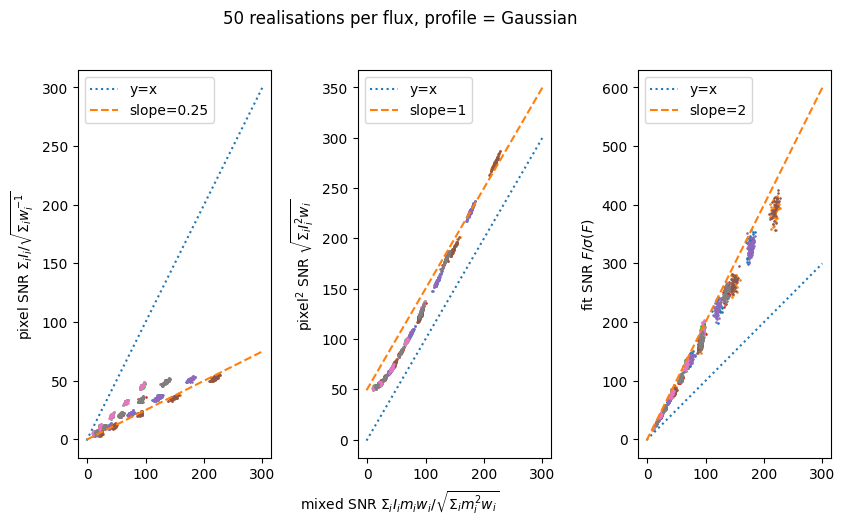

In [8]:
# Check SNR consistency

# The different SNR estimates on output from the fitting script are:

# SNR_pix   optimal-weight pixel sum     $\Sigma_i I_i / \sqrt{\Sigma_i w_i^{-1}}$

# SNR_pix2  square pixel sum             $\Sigma_i I_i^2 w_i / \sqrt{\Sigma_i I_i^2 w_i} = \sqrt{\Sigma_i I_i^2 w_i}$
# SNR_{key} ngmix v2 mixed s2n           $\Sigma_i I_i m_i w_i / \sqrt{\Sigma_i I_i^2 w_i}$
#           ngmix v1 model s2n           $\sqrt{\Sigma_i m_i^2 w_i}$

# F_{key}/sigma(F_{key})    fit SNR

fig, axes = plt.subplots(ncols=3, figsize=(9, 5), sharex=True)

s = 0.75

for key in keys:
    for direc in dirs:
        mydat = dat[direc]

        axes[0].scatter(mydat[f"SNR_{key}"], mydat["SNR_pix"], s=s)
        axes[1].scatter(mydat[f"SNR_{key}"], mydat["SNR_pix2"], s=s)
        axes[2].scatter(mydat[f"SNR_{key}"], mydat[f"flux_{key}"] / mydat[f"flux_err_{key}"], s=s)

fig.text(0.5, 0.04, "mixed SNR $\Sigma_i I_i m_i w_i / \sqrt{\Sigma_i m_i^2 w_i}$", ha='center', va='center')

axes[0].set_ylabel(r"pixel SNR $\Sigma_i I_i / \sqrt{\Sigma_i w_i^{-1}}$")
axes[1].set_ylabel(r"pixel$^2$ SNR $\sqrt{\Sigma_i I_i^2 w_i}$")
axes[2].set_ylabel(r"fit SNR $F / \sigma(F)$")


a_arr = [0.25, 1, 2]
c_arr = [0, 50, 0]

x_arr = np.arange(-1, 300, 0.1)
for idx in range(3):
    a = 1
    axes[idx].plot(x_arr, a*x_arr, ':', label=f"y=x")
    a = a_arr[idx]
    c = c_arr[idx]
    axes[idx].plot(x_arr, a*x_arr + c, '--', label=f"slope={a}")
    axes[idx].legend()
#axes[1].set_xlim(0, 100)
#axes[1].set_ylim(0, 100)

add_title(fig)
fig.tight_layout(rect=[0.05, 0.05, 1, 1])
plt.savefig("SNR_comp.png")

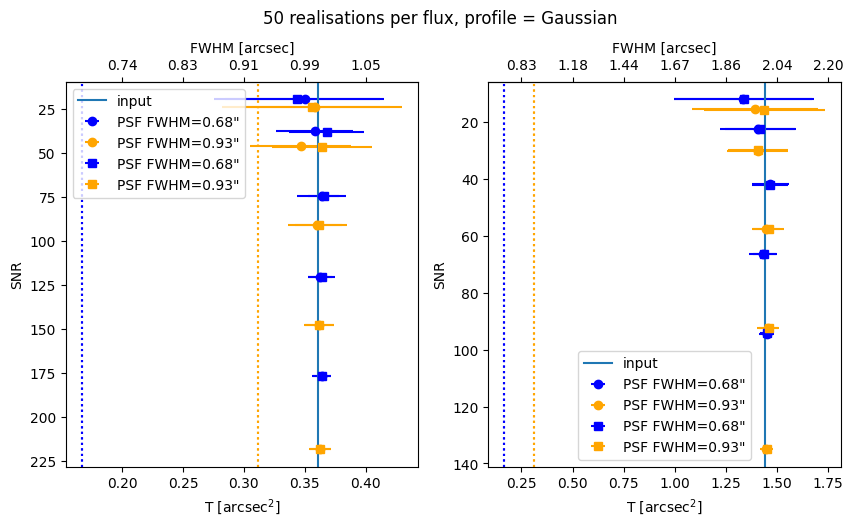

In [9]:
# Plot mean and std sizes

fig, axes = plt.subplots(ncols=len(gal_hlr_arr), figsize=(10, 5))

for idx, gal_hlr in enumerate(gal_hlr_arr): 
    for key in keys:
        for jdx, psf in enumerate(psf_arr):
            direc = f"gal_hlr_{gal_hlr}_psf_{psf}"
            label = f"PSF FWHM={psf}\""
            x = T_mean[key][direc]
            y = SNR_mean[key][direc]
            dx = T_std[key][direc]
            axes[idx].errorbar(
                x,
                y,
                xerr=dx,
                fmt=markers[key],
                label=label,
                color=color_arr[jdx]
            )

            T_psf = psf ** 2 / ( 4 * np.log(2) )
            axes[idx].axvline(x=T_psf, ls=":", color=color_arr[jdx])

    axes[idx].invert_yaxis()
    axes[idx].set_xlabel("T [arcsec$^2$]")
    axes[idx].set_ylabel("SNR")

    axes[idx].axvline(x=T_gal[idx], ls="-", label="input")
    axes[idx].legend()
    
    ax2 = axes[idx].secondary_xaxis('top')

    # Define the tick positions of the first x-axis = T
    x_ticks = axes[idx].get_xticks()

    # Apply the transformation FWHM = 2 sqrt(ln 2 * T)
    new_x_ticks = 2 * np.sqrt(np.log(2) * x_ticks)

    # Set the new ticks and labels for the second x-axis
    ax2.set_xticks(x_ticks)
    ax2.set_xticklabels([f'{tick:.2f}' for tick in new_x_ticks])
    ax2.set_xlabel(r'FWHM [arcsec]')

add_title(fig)
fig.savefig(f"T.png")

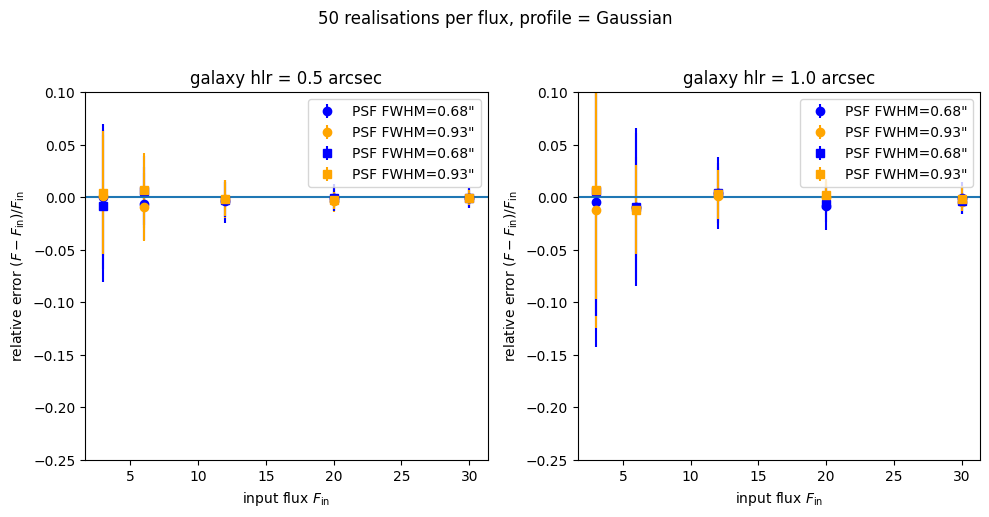

In [10]:
# Plot mean and std fluxes

fig, axes = plt.subplots(ncols=len(gal_hlr_arr), figsize=(10, 5))

for idx, gal_hlr in enumerate(gal_hlr_arr): 
    for key in keys:
        for jdx, psf in enumerate(psf_arr):
            direc = f"gal_hlr_{gal_hlr}_psf_{psf}"
            label = f"PSF FWHM={psf}\""
            x = np.array(fluxes)
            y = flux_mean[key][direc]
            axes[idx].errorbar(
                x,
                (y - x) / x,
                yerr=flux_std[key][direc] / x,
                fmt=markers[key],
                label=label,
                color=color_arr[jdx]
            )
            
    axes[idx].set_xlabel(r"input flux $F_{\rm in}$")
    axes[idx].set_ylabel(r"relative error $(F - F_{\rm in}) / F_{\rm in}$")
    axes[idx].set_title(f"galaxy hlr = {gal_hlr} arcsec")
    axes[idx].set_ylim(-0.25, 0.1)
    axes[idx].axhline(y=0)
    axes[idx].legend()

add_title(fig)
fig.tight_layout()
fig.savefig(f"dF.png")

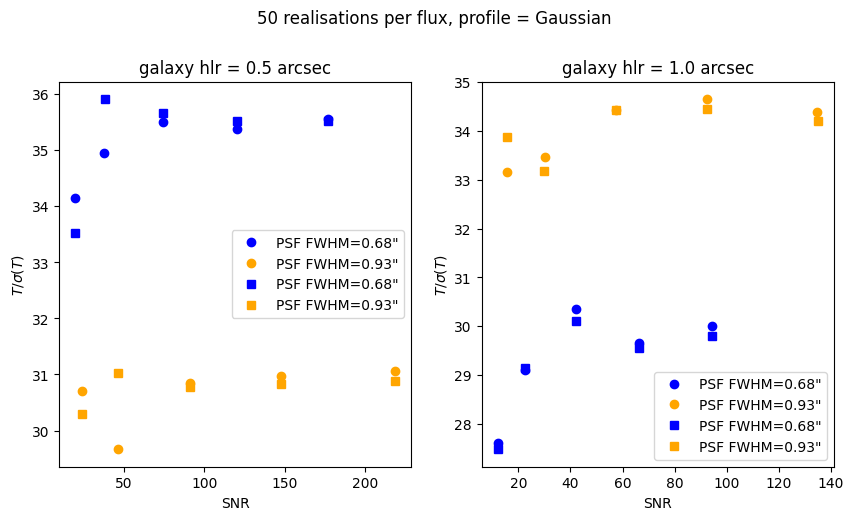

In [11]:
# Plot SNR estimates: size

fig, axes = plt.subplots(ncols=len(gal_hlr_arr), figsize=(10, 5))

for idx, gal_hlr in enumerate(gal_hlr_arr): 
    for key in keys:
        for jdx, psf in enumerate(psf_arr):
            direc = f"gal_hlr_{gal_hlr}_psf_{psf}"
            label = f"PSF FWHM={psf}\""
            x = SNR_mean[key][direc]
            y = np.array(T_mean[key][direc]) / np.array(T_err[key][direc])
            axes[idx].errorbar(
                x,
                y,
                fmt=markers[key],
                label=label,
                color=color_arr[jdx]
            )
            
    axes[idx].set_xlabel(r"SNR")
    axes[idx].set_ylabel(r"$T / \sigma(T)$")
    axes[idx].set_title(f"galaxy hlr = {gal_hlr} arcsec")
    #axes[idx].set_ylim(-0.25, 0.1)
    axes[idx].legend()

fig.savefig(f"SNR_TdT.png")
add_title(fig)

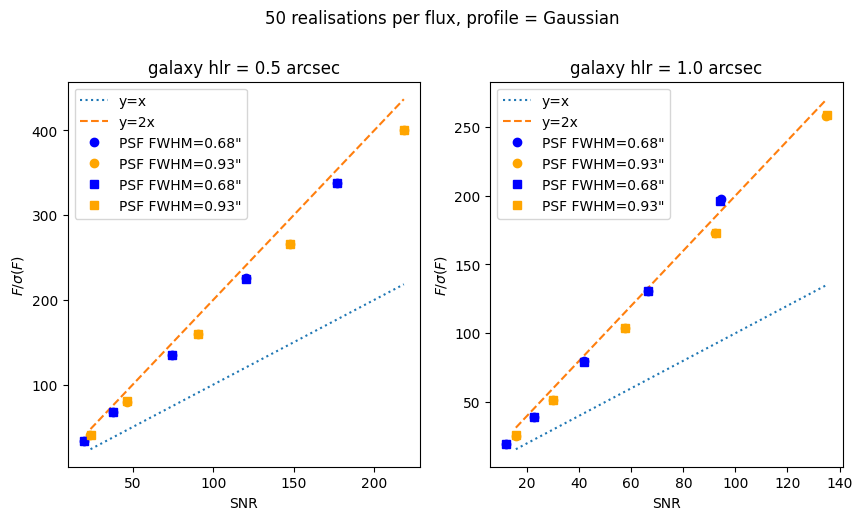

In [12]:
# Plot SNR estimates: size

fig, axes = plt.subplots(ncols=len(gal_hlr_arr), figsize=(10, 5))

for idx, gal_hlr in enumerate(gal_hlr_arr): 
    for key in keys:
        for jdx, psf in enumerate(psf_arr):
            direc = f"gal_hlr_{gal_hlr}_psf_{psf}"
            label = f"PSF FWHM={psf}\""
            x = SNR_mean[key][direc]
            y = np.array(flux_mean[key][direc]) / np.array(flux_err[key][direc])
            axes[idx].errorbar(
                x,
                y,
                fmt=markers[key],
                label=label,
                color=color_arr[jdx]
            )
            
    axes[idx].set_xlabel(r"SNR")
    axes[idx].set_ylabel(r"$F / \sigma(F)$")
    axes[idx].set_title(f"galaxy hlr = {gal_hlr} arcsec")
    #axes[idx].set_ylim(-0.25, 0.1)

    x_arr = np.arange(x[0], x[-1], 0.1)
    a = 1
    axes[idx].plot(x_arr, a*x_arr, ':', label=f"y=x")
    a = 2
    axes[idx].plot(x_arr, a*x_arr, '--', label=f"y={a}x")

    axes[idx].legend()

fig.savefig(f"SNR_FdF.png")
add_title(fig)

TypeError: can't multiply sequence by non-int of type 'numpy.float64'

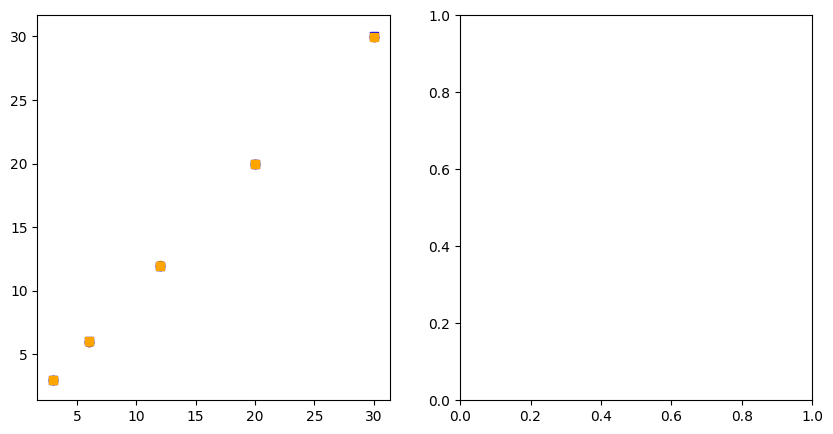

In [13]:
# Plot flux estimates

def model_fct(params, x):
    
    return params["m"] * x + params["c"]

def loss_fct(params, x_data, y_data, err):
    
    y_model = model_fct(params, x_data)
    
    return (y_model - y_data) / err


fig, axes = plt.subplots(ncols=len(gal_hlr_arr), figsize=(10, 5))

x_arr = None

for idx, gal_hlr in enumerate(gal_hlr_arr): 
    x_all = []
    y_all = []
    dy_all = []
    for key in keys:
        for jdx, psf in enumerate(psf_arr):
            direc = f"gal_hlr_{gal_hlr}_psf_{psf}"
            label = f"PSF FWHM={psf}\""

            x = np.array(fluxes)
            y = flux_mean[key][direc]
            dy = flux_std[key][direc]
            axes[idx].errorbar(
                x,
                y,
                yerr=dy,
                fmt=markers[key],
                label=label,
                color=color_arr[jdx]
            )

            if x_arr is None:
                x_arr = np.arange(x[0], x[-1], 0.1)

            x_all.append(x)
            y_all.append(y)
            dy_all.append(dy)
            
    params = Parameters()                                              
    params.add("m", value=0.01)                                              
    params.add("c", value=0.01)
    res = minimize(loss_fct, params, args=(x_all, y_all, dy_all))
    axes[idx].plot(x_arr, model_fct(params.res, x_arr))
            
    axes[idx].set_xlabel(r"input flux $F_{\rm in}$")
    axes[idx].set_ylabel(r"measured flux $F$")
    axes[idx].set_title(f"galaxy hlr = {gal_hlr} arcsec")
    axes[idx].plot(x_arr, x_arr, ':', label=f"y=x")
    axes[idx].legend()

add_title(fig)
fig.savefig(f"F.png")

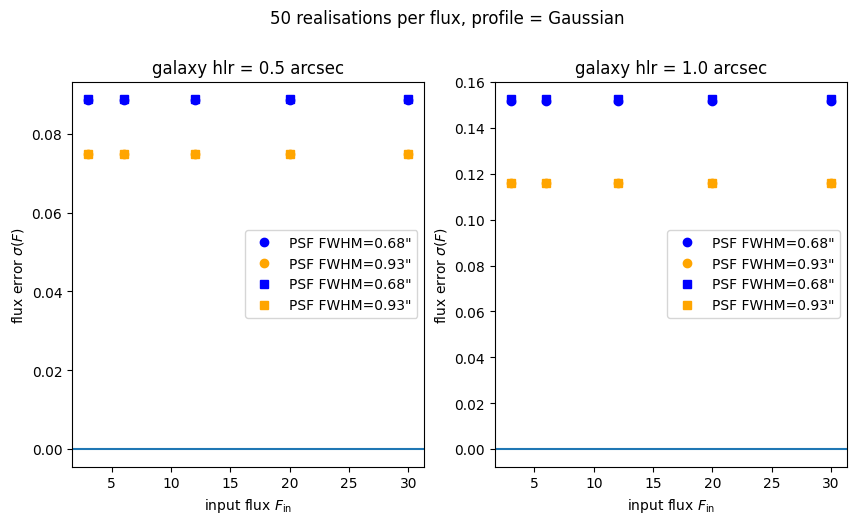

In [42]:
# Plot flux error estimates

fig, axes = plt.subplots(ncols=len(gal_hlr_arr), figsize=(10, 5))

for idx, gal_hlr in enumerate(gal_hlr_arr): 
    for key in keys:
        for jdx, psf in enumerate(psf_arr):
            direc = f"gal_hlr_{gal_hlr}_psf_{psf}"
            label = f"PSF FWHM={psf}\""
            x = np.array(fluxes)
            y = flux_err[key][direc]
            axes[idx].errorbar(
                x,
                y,
                fmt=markers[key],
                label=label,
                color=color_arr[jdx]
            )
            
    axes[idx].set_xlabel(r"input flux $F_{\rm in}$")
    axes[idx].set_ylabel(r"flux error $\sigma(F)$")
    axes[idx].set_title(f"galaxy hlr = {gal_hlr} arcsec")
    axes[idx].axhline(y=0)
    axes[idx].legend()

add_title(fig)
fig.savefig(f"F_err.png")
